# Geometry optimization

## Manual determination of a bond length

The **equilibrium bond length** of a CO molecule is approximately the bond length that ***minimizes** the total energy. We can find that by computing the total energy as a function of bond length, and noting where the minimum is. 

Here is an example in VASP. There are a few features to point out here. We want to compute 5 bond lengths, and each calculation is independent of all the others. vasp is set up to automatically handle jobs for you by submitting them to the queue. It raises a variety of exceptions to let you know what has happened, and you must handle these to control the workflow. We will illustrate this by the following examples.

In [6]:
from ase import Atoms, Atom
from gpaw import GPAW, PW
import matplotlib.pyplot as plt
import numpy as np

In [69]:
# gpaw calculator:
calc = GPAW(mode=PW(550),       # planewave cutoff  350
            xc='PBE',             # the exchange-correlation functional
            nbands=6,             # number of bands
            occupations={'name': 'methfessel-paxton', 'width': 0.01, 'order': 0},    # Methfessel-Paxton smearing
            txt='molecules/simple_CO.out')   # output file

bond_lengths = [1.05, 1.1, 1.15, 1.2, 1.25]
energies = []
# possible bond lengths
for d in bond_lengths:  
    atoms = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [d, 0, 0])],
            cell=(6, 6, 6))
    atoms.calc = calc
    en = atoms.get_potential_energy()
    energies.append(en)
    calc.write('molecules/simple_CO_d{}.gpw'.format(d))  # write restart file

In [37]:
from scipy.optimize import curve_fit, fmin

## Fitting
def func(x,a,b,c,d):
    x = np.asarray(x)
    f = a + b*x + c*x**2 + d*x**3
    return f
fit_param, _ = curve_fit(func, bond_lengths, energies)

## evaluate 
grid = np.linspace(min(bond_lengths), max(bond_lengths), 50)
y_eval = func(grid, *fit_param)

## find min of func in a range
odd = min((func(x, *fit_param), x) for x in grid)

print('minimum value is {}'.format(odd))

minimum value is (-14.953495784184156, 1.139795918367347)


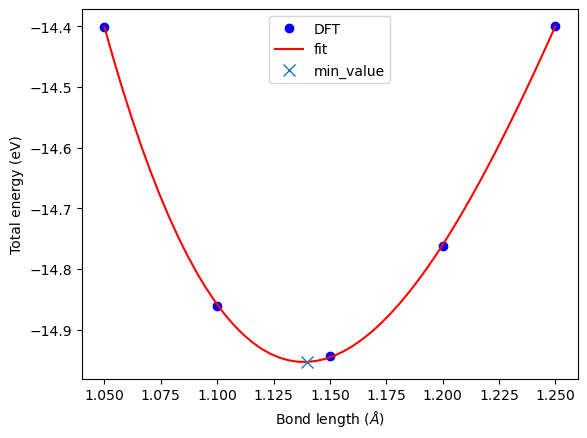

In [36]:
## Plot
plt.plot(bond_lengths, energies, 'bo', label='DFT')
plt.plot(grid, y_eval, 'r-', label='fit')
plt.plot(odd[1],odd[0], 'x', ms=8, label='min_value')
plt.xlabel(r'Bond length ($\AA$)')
plt.ylabel('Total energy (eV)')
plt.legend(loc='upper center')
plt.show()

## Automatic geometry optimization

It is generally the case that the **equilibrium geometry*** of a system is the one that *minimizes the total energy and forces*. Since each atom has three degrees of freedom, you can quickly get a high dimensional optimization problem. Then the optimizer (normally implemeted in DFT code) is needed.

Here, we use [`ASE optimizer`](https://wiki.fysik.dtu.dk/ase/ase/optimize.html#module-ase.optimize) to iteratively find the structural energy minimum. The criterion for stopping geometry optimization process can be:
- when the change in energy between two steps is less than a certain value
- when the force on all individual atoms less than a certain value. 
- Or minimization top (without convergence) if it reaches maximum steps

The geometry optimization may called the relaxation.

The optimization algorithms can be roughly divided into:
- local optimization algorithms which find a nearby local minimum
- global optimization algorithms that try to find the global minimum (a much harder task).

The following code base on [this link](https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/H2/optimization.html)

In [55]:
from gpaw import GPAW, PW
from ase.optimize.sciopt import SciPyFminCG

calc = GPAW(mode=PW(550),       # planewave cutoff  350
            xc='PBE',             # the exchange-correlation functional
            nbands=6,             # number of bands
            occupations={'name': 'methfessel-paxton', 'width': 0.01, 'order': 0},    # Methfessel-Paxton smearing
            txt=None)   

mol = Atoms([Atom('C', [0, 0, 0]),
        Atom('O', [1.2, 0, 0])],
        cell=(6, 6, 6))
mol.center()       
mol.calc = calc

e0 = mol.get_potential_energy()
d0 = mol.get_distance(0, 1)

# Find the theoretical bond length (optimize)
relax = SciPyFminCG(mol)             # logfile=None
relax.run(fmax=0.05)

e1 = mol.get_potential_energy()
d1 = mol.get_distance(0, 1)
#####
print('\nexperimental bond length:')
print('CO molecule energy: {} eV'.format(e0))
print('bondlength        : {} Ang'.format(d0))

print('\nPBE energy minimum:')
print('CO molecule energy: {} eV'.format(e1))
print('bondlength        : {} Ang'.format(d1))

             Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
SciPyFminCG:    0 01:37:52      -14.761241*       5.6791
SciPyFminCG:    1 01:38:05      -14.949139*       0.5675
SciPyFminCG:    2 01:38:13      -14.950557*       0.0123

experimental bond length:
CO molecule energy: -14.761240927629466 eV
bondlength        : 1.1999999999999997 Ang

PBE energy minimum:
CO molecule energy: -14.950557085202906 eV
bondlength        : 1.1381327677002044 Ang


## Relaxation of a water molecule

It is not more complicated to relax more atoms, it just may take longer because there are more electrons and degrees of freedom. Here we relax a water molecule which has three atoms.

In [63]:
from gpaw import GPAW, PW
from ase.optimize import QuasiNewton

calc = GPAW(mode=PW(550),       # planewave cutoff  350
            xc='PBE',             # the exchange-correlation functional
            nbands=6,             # number of bands
            occupations={'name': 'methfessel-paxton', 'width': 0.01, 'order': 0},    # Methfessel-Paxton smearing
            txt=None)   

atoms = Atoms([Atom('H', [0.5960812, -0.7677068, 0.0000000]),
               Atom('O', [0.0000000,  0.0000000, 0.0000000]),
               Atom('H', [0.5960812,  0.7677068, 0.0000000])],
              cell=(8, 8, 8))
atoms.center()
mol.calc = calc

# Optimize
relax = QuasiNewton(mol)          # logfile=None
relax.run(fmax=1e-3)

forces = mol.get_forces()
print(forces)
calc.write('molecules/H2O_relax.gpw')

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 01:50:31      -14.950782*       0.0014
BFGSLineSearch:    1[  6] 01:50:37      -14.950782*       0.0016
BFGSLineSearch:    2[ 14] 01:50:43      -14.950782*       0.0014
BFGSLineSearch:    3[ 16] 01:50:45      -14.950782*       0.0006
[[ 0.00061177  0.          0.        ]
 [-0.00045795  0.          0.        ]]


Visualize trajectory ...